In [1]:
import numpy as np
import sys
sys.path.insert(1,'./src/')
from models import ChemicalReactionNetwork
from matplotlib import pyplot as plt
from tqdm import tqdm
import corner
from copy import deepcopy
from statsmodels.tsa.stattools import acf

See [description of this notebook](./questions.md/#july-17th-non-abc)

In [2]:
species = 'A B C'.split()
reactions = [
    ({'A': 1}, {'B': 1}),
    ({'B': 1}, {'A': 1}),
    ({'B': 1}, {'C': 1}),
    ({'C': 1}, {'B': 1}),
]

switch_reaction = {
    0: 3,
    1: 2,
    2: 1,
    3: 0
}

kinetic_rates = np.array([2e-1,1,1,2e-1])
# some of the kinetic rates has to equal. 

model = ChemicalReactionNetwork(reactions, species, kinetic_rates)

X_init = np.array([10,20,30])

T = 6

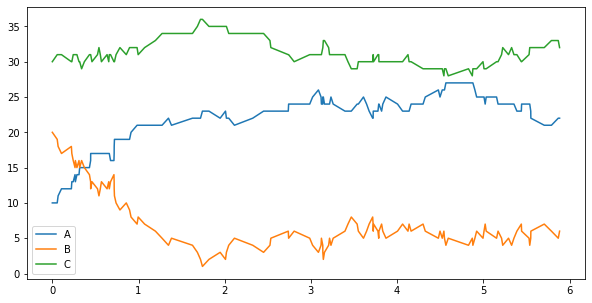

In [3]:
x,r,t = model.gilespie(X_init,T)
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,x[:,i],label=species[i])
plt.legend();

the observables are only copy number of `B`, so our observation should be that:


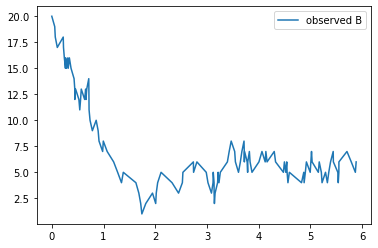

In [4]:
b = model.get_observation(t,x,'B').flatten()
plt.plot(t,b,label='observed B')
plt.legend();

Now, let's think what's in a state:

- reaction time $t_i$
- populations of the 3 species $a_i,b_i,c_i$

So the first step is to generate an initial state based on our observation. 

The observation provides for us the $t_i,a_i$. I will use a random number generator to generate an initial guess of $b_i, c_i$


In [5]:
def get_r(a,c):
    r = np.zeros(len(a)-1,dtype=int)
    
    diff_a = np.diff(a,1)
    diff_c = np.diff(c,1)
    r[diff_a==-1] = 0
    r[diff_a==1] = 1
    r[diff_c==1] = 2
    r[diff_c==-1] = 3
    
    return r

def log_likelihood(state):
    k,a,b,c = state
    r = get_r(a,c)
    X = np.array([a,b,c]).T
    return model.gilespie_exact_log_likelihood(k,X,r,t,T)
    # should this thing be modified a bit? as it is conditioned on fixing b and fixing t. 
    # No, it is still correct up to a constant. so it won't matter in MCMC. 

In [6]:
total_copy_number = np.sum(x[0])

def generate_initial_state(b,t,total_copy_number=total_copy_number):
    cond = True
    while cond:
        
        k = np.random.uniform(0,0.5,len(kinetic_rates)) + kinetic_rates
        a0 = np.random.randint(0,total_copy_number  - b[0])
        
        diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
        diff_a = np.zeros(shape=diff_b.shape,dtype=int)
        
        for i,db in enumerate(diff_b):
            if np.random.uniform() < 0.5:
                diff_a[i] = -db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else: cond = (log_likelihood((k,a,b,c)) == -np.inf)
    return [k,a,b,c]

def generate_good_initial_state(b,t,total_copy_number=total_copy_number):
    state = generate_initial_state(b,t,total_copy_number)
    likelihood = log_likelihood(state)
    for i in range(20):
        new_state = generate_initial_state(b,t,total_copy_number)
        new_likelihood = log_likelihood(new_state)
        if new_likelihood > likelihood:
            state = new_state
            likelihood = new_likelihood
    return state

In [7]:
true_state = (kinetic_rates,x[:,0],x[:,1],x[:,2])
log_likelihood(true_state)

97.02370039671355

In [8]:
initial_state = generate_good_initial_state(b,t)
k,a,b,c = initial_state
log_likelihood(initial_state)

/home/haiyang/proj/ABC22/./src/models.py:280: RuntimeWarning: divide by zero encountered in log
  log_pdf_r = np.sum(np.log([rr[i] for rr, i in zip(A, r)])) - np.sum(


91.64710485083297

Text(0.5, 1.0, 'initial state')

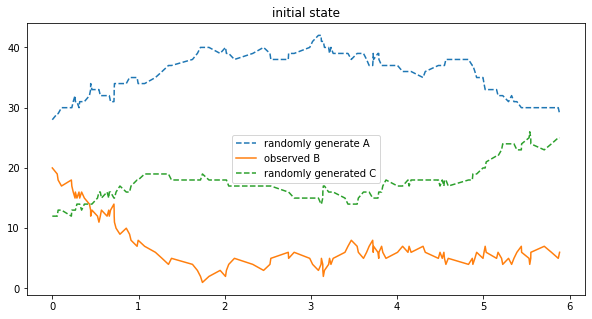

In [9]:
plt.figure(figsize=(10,5))
plt.plot(t,a,'--',label='randomly generate A')
plt.plot(t,b,label='observed B')
plt.plot(t,c, '--', label='randomly generated C')
plt.legend()
plt.title('initial state')

In this particular partial implementation, the only things we can change are 
- kinetic rates
- interchanging reactions 2 and 3. i.e. $B \xLeftrightarrow[k_4]{k_3} C$
- the initial population of the $B,C$

In [10]:
def get_box(k, box_size):

    box = []
    volume = 1

    for t in k:
        lower = max(t-box_size, 0)
        upper = t+box_size
        box.append((lower, upper))
        volume *= (upper-lower)

    box = np.array(box).T

    return box, volume

def move_k(state, box_size=0.08):
    k, a, b, c = deepcopy(state)
    box, volume = get_box(k, box_size)
    new_k = np.random.uniform(*box)

    _, volume2 = get_box(new_k, box_size)

    return (new_k, a, b, c), np.log(volume/volume2)


def get_poss(state):
    _, a, b, c = state
    
    r = np.insert(get_r(a,c),0,-1)
    a_min = np.minimum.accumulate(a[::-1])[::-1]
    c_min = np.minimum.accumulate(c[::-1])[::-1]
    
    possibilities = list(np.where((a_min > 0) & ((r==1) | (r==3)))[0]) + list(np.where((c_min > 0) & ((r==0) | (r==2)))[0])

    if a_min[0] > 0 :
        possibilities.append(0)

    if c_min[0] > 0 :
        possibilities.append(-1)
    return np.random.choice(possibilities), r, len(possibilities)

def move_copy_number(state,n_steps=1,log_prob=0):
    '''
    this is merged with moving the initial copy number. 
    '''
    if n_steps == 0:
        return state, 0
    if n_steps == 1:
        poss,r,p = get_poss(state)
        k,a,b,c = deepcopy(state)
        
        if poss == 0:
            a += -1
            c += 1
        
        elif poss == -1:
            a += 1
            c += -1
        else:
            if r[poss] in [1,3]:
                a[poss:] += -1
                c[poss:] += 1
            else:
                a[poss:] += 1
                c[poss:] += -1
                
        new_state = (k,a,b,c)
        _,_, q = get_poss(new_state)
        return (k,a,b,c), np.log(p/q) + log_prob
    if n_steps > 1:
        new_state, log_prob = move_copy_number(state,1,log_prob)
        return move_copy_number(new_state,n_steps-1,log_prob)

In [11]:
def mcmc(initial_state, n):

    samples = [initial_state]
    if_accepted = []
    log_likelihoods = [log_likelihood(initial_state)]

    for i in tqdm(range(n), desc='sampling state space'):
        
        if np.random.uniform() < 0.5:
            move = 1
            new_state, log_p = move_copy_number(samples[-1],n_steps=1)
        else:
            move = 2
            new_state, log_p = move_k(samples[-1])
        
        curr_log_pst = log_likelihood(new_state)
        log_acceptance = curr_log_pst + log_p - log_likelihoods[-1]
        if log_acceptance >= 0 or np.log(np.random.uniform()) < log_acceptance:
            samples.append(new_state)
            log_likelihoods.append(curr_log_pst)
            if_accepted.append(move)
        else:
            samples.append(samples[-1])
            log_likelihoods.append(log_likelihoods[-1])
            if_accepted.append(0)
    return samples, np.array(if_accepted), np.array(log_likelihoods)

I am going to have a test on the move_state function

In [12]:
pst_samples,if_accepcted, log_likelihoods = mcmc(initial_state, n=int(2e5))

sampling state space: 100%|██████████| 200000/200000 [20:49<00:00, 160.08it/s]


In [13]:
print('rejection rate:', np.sum(if_accepcted==0)/len(if_accepcted))
print('moving path:', np.sum(if_accepcted==1)/len(if_accepcted))
print('moving kinetic rates:', np.sum(if_accepcted==2)/len(if_accepcted))

rejection rate: 0.698455
moving path: 0.130825
moving kinetic rates: 0.17072


In [14]:
pst_k = np.array([i[0] for i in pst_samples])

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

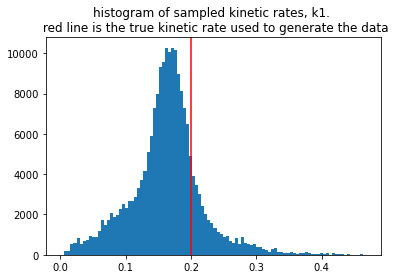

In [15]:
plt.hist(pst_k[:,0], bins=100)
plt.axvline(kinetic_rates[0], color='r')
plt.title('histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

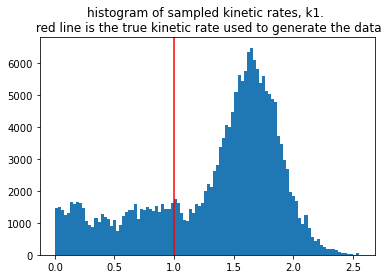

In [16]:
plt.hist(pst_k[:,1], bins=100)
plt.axvline(kinetic_rates[1], color='r')
plt.title('histogram of sampled kinetic rates, k1. \n red line is the true kinetic rate used to generate the data')

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k3. \n red line is the true kinetic rate used to generate the data')

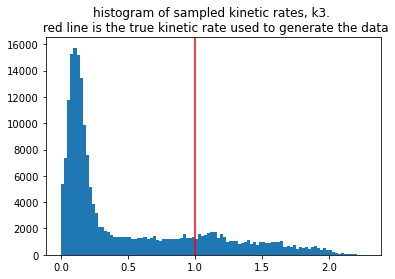

In [17]:
plt.hist(pst_k[:,2], bins=100)
plt.axvline(kinetic_rates[2], color='r')
plt.title('histogram of sampled kinetic rates, k3. \n red line is the true kinetic rate used to generate the data')

Text(0.5, 1.0, 'histogram of sampled kinetic rates, k4. \n red line is the true kinetic rate used to generate the data')

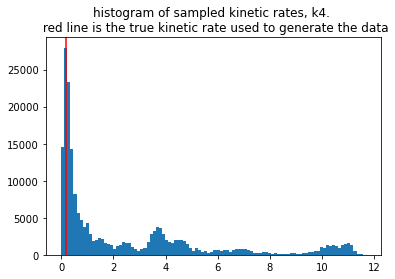

In [18]:
plt.hist(pst_k[:,3], bins=100)
plt.axvline(kinetic_rates[3], color='r')
plt.title('histogram of sampled kinetic rates, k4. \n red line is the true kinetic rate used to generate the data')

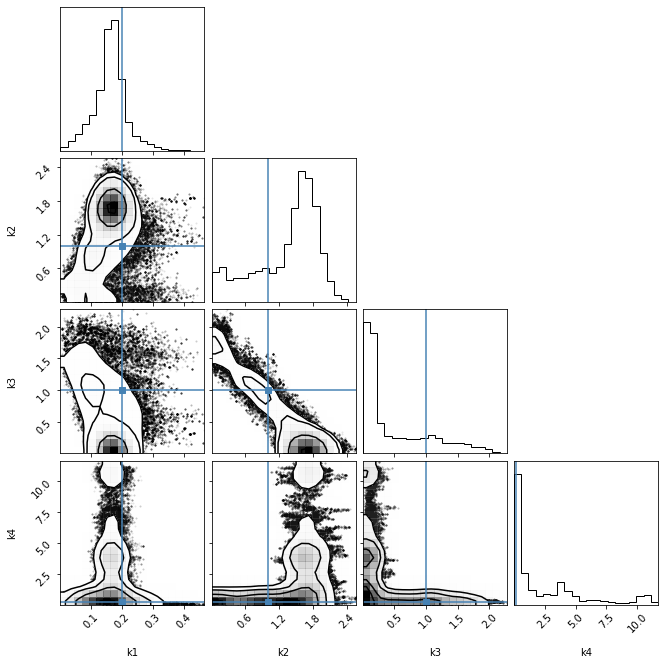

In [19]:
corner.corner(pst_k[1000:], labels=['k1','k2','k3','k4'], truths=kinetic_rates, smooth=1);

Text(0.5, 1.0, 'autocorrelation of k1')

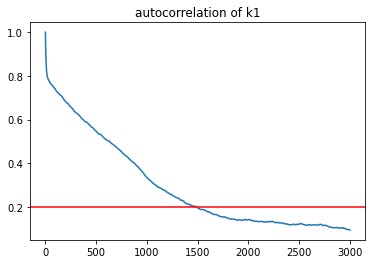

In [28]:
plt.plot(acf(pst_k[1000:,0],nlags=3000))
plt.axhline(0.2, color='r')
plt.title('autocorrelation of k1')

In [21]:
log_likelihood(pst_samples[-1])

150.59630129698135

In [22]:
log_likelihood(true_state)

97.02370039671355

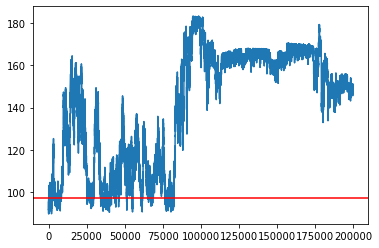

In [23]:
plt.plot(log_likelihoods,label='log likelihoods of MCMC samples')
plt.axhline(log_likelihood(true_state), color='r', label='true state')

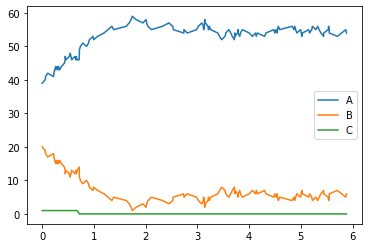

In [29]:
for i in range(3):
    plt.plot(t,pst_samples[np.argmax(log_likelihoods)][i+1], label=model.index2chemical[i])
plt.legend();

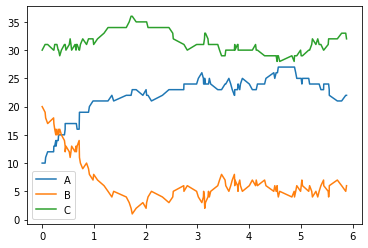

In [26]:
for i in range(3):
    plt.plot(t,true_state[i+1], label=model.index2chemical[i])
plt.legend();